# SQuAD v2 simple categorisation

- Wh- questions __[DONE]__
- Answerable vs. unanswerable __[DONE]__
- Answer types
- Context length __[DONE]__
- Question length __[DONE]__
- Answer length __[DONE]__
- TREC question classification?
- The ones we already have manually labelled
- Manual labelling of a diagnostic AdversarialQA dataset?
- Evaluate on MRQA datasets
- Type consistency (from undersensitivity paper)?
- Clustering (e.g. DBScan)
- Clustering based on learning trajectories
- Item Response Theory
- Fully-trained uncertainty buckets
- CheckList

## Questions

- Why do some examples have only 1/2 answers - wasn't there a minimum number of answers needed?
- Compare distributions of various classes of question between training and dev set

Resolved:
- Dev set has more than one answer - confirm which is used for computing metrics
    - A: "We take the maximum F1 over all of the ground truth answers for a given question, and then average over all of the questions." (SQuAD v1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datasets import load_dataset
import spacy
import os

nlp = spacy.load('en_core_web_sm')

In [2]:
os.chdir('../..')

In [3]:
squad_v2_val = load_dataset('squad_v2', split='validation')

Reusing dataset squad_v2 (/Users/stevengeorge/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/ba48bc29b974701e9ba8d80ac94f3e3df924aba41b764dcf9851debea7c672e4)


In [4]:
squad_v2_val

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 11873
})

In [5]:
squad_v2_val_df = pd.DataFrame(squad_v2_val)
print(squad_v2_val_df.shape)
squad_v2_val_df.head()

(11873, 5)


,answers,context,id,question,title
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans


In [6]:
squad_v2_val_df['id'].nunique()

11873

In [7]:
squad_v2_val_df.loc[1]['answers']

{'answer_start': [94, 87, 94, 94],
 'text': ['10th and 11th centuries',
  'in the 10th and 11th centuries',
  '10th and 11th centuries',
  '10th and 11th centuries']}

In [8]:
print(squad_v2_val_df.loc[1]['context'][94:])
print('\n')
print(squad_v2_val_df.loc[1]['context'][87:])

10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.


in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the nativ

In [9]:
squad_v2_val_df = pd.concat((squad_v2_val_df, squad_v2_val_df['answers'].apply(pd.Series)), axis=1)
squad_v2_val_df.head()

,answers,context,id,question,title,answer_start,text
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans,"[159, 159, 159, 159]","[France, France, France, France]"
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans,"[94, 87, 94, 94]","[10th and 11th centuries, in the 10th and 11th..."
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans,"[256, 256, 256, 256]","[Denmark, Iceland and Norway, Denmark, Iceland..."
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans,"[308, 308, 308, 308]","[Rollo, Rollo, Rollo, Rollo]"
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans,"[671, 649, 671, 671]","[10th century, the first half of the 10th cent..."


In [10]:
squad_v2_val_df['answer_start'].apply(len).value_counts().sort_index()

0    5945
1       1
2      88
3    4238
4     625
5     945
6      31
Name: answer_start, dtype: int64

In [11]:
# Example with single answer
print("Context:")
print(squad_v2_val_df[squad_v2_val_df['answer_start'].apply(len) == 1]['context'].item())
print("\n")

print("Question:")
print(squad_v2_val_df[squad_v2_val_df['answer_start'].apply(len) == 1]['question'].item())
print("\n")

print("Answer:")
print(squad_v2_val_df[squad_v2_val_df['answer_start'].apply(len) == 1]['text'].item())
print("\n")

Context:
The common allotrope of elemental oxygen on Earth is called dioxygen, O
2. It is the form that is a major part of the Earth's atmosphere (see Occurrence). O2 has a bond length of 121 pm and a bond energy of 498 kJ·mol−1, which is smaller than the energy of other double bonds or pairs of single bonds in the biosphere and responsible for the exothermic reaction of O2 with any organic molecule. Due to its energy content, O2 is used by complex forms of life, such as animals, in cellular respiration (see Biological role). Other aspects of O
2 are covered in the remainder of this article.


Question:
What is the scientific designation of oxygen?


Answer:
['O2']




In [12]:
squad_v2_val_df['unanswerable'] = np.where(
    squad_v2_val_df['answer_start'].apply(len) == 0,
    1,
    0
)
squad_v2_val_df['unanswerable'].sum()

5945

## Who, what, where, when, why, which, how

In [13]:
W8H_LABELS = ['what', 'how', 'who', 'when', 'which', 'where', 'why']

In [14]:
w8h_df = squad_v2_val_df.copy()

In [15]:
w8h_df.head()

,answers,context,id,question,title,answer_start,text,unanswerable
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans,"[159, 159, 159, 159]","[France, France, France, France]",0
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans,"[94, 87, 94, 94]","[10th and 11th centuries, in the 10th and 11th...",0
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans,"[256, 256, 256, 256]","[Denmark, Iceland and Norway, Denmark, Iceland...",0
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans,"[308, 308, 308, 308]","[Rollo, Rollo, Rollo, Rollo]",0
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans,"[671, 649, 671, 671]","[10th century, the first half of the 10th cent...",0


In [16]:
w8h_df['w8h_label'] = w8h_df['question'].apply(lambda x: x.lower().split()[0])  # First word as category

In [17]:
w8h_df['w8h_label'] = np.where(
    w8h_df['w8h_label'].isin(W8H_LABELS),
    w8h_df['w8h_label'],
    'other'
)

In [18]:
w8h_df['w8h_label'].value_counts()

what     5813
other    2255
how      1133
who       984
when      736
where     429
which     336
why       187
Name: w8h_label, dtype: int64

In [19]:
print("'Other' questions:")
for qn in w8h_df[w8h_df['w8h_label'] == 'other'].sample(n=10)['question']:
    print('- ', qn)

'Other' questions:
-  Packets can be delivered via what route?
-  In which Illinois city is the Marine Biological Laboratory located?
-  People of what nationality invented the HMS Dreadnought?
-  Complex devices such as weighing scales are used when measuring what?
-  George C. Walker served as trustee, treasurer and donor of what?
-  His poem is considered the first kind of what type of protest?
-  A decline in Scottish nationalism during the 1960s fueled what?
-  Specific relativity offers an equivalence between what?
-  Whwn forces are at right ngles to each other what can they be broken down to?
-  In what decade were injectors widely used in jet engines?


In [20]:
for qn in w8h_df[w8h_df['w8h_label'] == 'who'].sample(n=10)['question']:
    print('- ', qn)

-  Who led the attack on Spain in 1565?
-  Who established the amount of prime numbers in existence?
-  Who can be in the Victorian cabinet?
-  Who showed that blogging increases precipitation in the Amazon?
-  Who voted against Jacksonville's annexation?
-  Who is to blame for acting unjustly?
-  Who patented a high-pressure compound engine in 1805?
-  Who feared that Holland might establish their own settlement?
-  Who was Boleslaw II of Masovia?
-  Who asks supplementary questions and then a general question of the First Minister?


In [21]:
w8h_df.head()

,answers,context,id,question,title,answer_start,text,unanswerable,w8h_label
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans,"[159, 159, 159, 159]","[France, France, France, France]",0,other
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans,"[94, 87, 94, 94]","[10th and 11th centuries, in the 10th and 11th...",0,when
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans,"[256, 256, 256, 256]","[Denmark, Iceland and Norway, Denmark, Iceland...",0,other
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans,"[308, 308, 308, 308]","[Rollo, Rollo, Rollo, Rollo]",0,who
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans,"[671, 649, 671, 671]","[10th century, the first half of the 10th cent...",0,what


In [22]:
w8h_df = w8h_df[['id', 'w8h_label']]

## Length metrics

- Context length
- Answer length (average over answers)
- Question length

In [23]:
squad_v2_val_df.head()

,answers,context,id,question,title,answer_start,text,unanswerable
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans,"[159, 159, 159, 159]","[France, France, France, France]",0
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans,"[94, 87, 94, 94]","[10th and 11th centuries, in the 10th and 11th...",0
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans,"[256, 256, 256, 256]","[Denmark, Iceland and Norway, Denmark, Iceland...",0
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans,"[308, 308, 308, 308]","[Rollo, Rollo, Rollo, Rollo]",0
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans,"[671, 649, 671, 671]","[10th century, the first half of the 10th cent...",0


In [24]:
length_df = squad_v2_val_df.copy()

In [25]:
length_df['context_length'] = length_df['context'].apply(lambda x: len(x.split()))

In [26]:
length_df['question_length'] = length_df['question'].apply(lambda x: len(x.split()))

In [27]:
length_df['text_lengths'] = length_df['text'].apply(lambda x: [len(y.split()) for y in x])

In [28]:
length_df.head()

,answers,context,id,question,title,answer_start,text,unanswerable,context_length,question_length,text_lengths
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans,"[159, 159, 159, 159]","[France, France, France, France]",0,113,6,"[1, 1, 1, 1]"
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans,"[94, 87, 94, 94]","[10th and 11th centuries, in the 10th and 11th...",0,113,6,"[4, 6, 4, 4]"
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans,"[256, 256, 256, 256]","[Denmark, Iceland and Norway, Denmark, Iceland...",0,113,7,"[4, 4, 4, 4]"
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans,"[308, 308, 308, 308]","[Rollo, Rollo, Rollo, Rollo]",0,113,5,"[1, 1, 1, 1]"
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans,"[671, 649, 671, 671]","[10th century, the first half of the 10th cent...",0,113,10,"[2, 7, 1, 1]"


In [29]:
length_df['answer_mode_length'] = (
    length_df['text_lengths']
        .apply(lambda x: stats.mode(x)[0])
        .apply(lambda x: x[0] if len(x) > 0 else 0)  # Select first modal value
)

In [30]:
length_df = length_df[['id', 'context_length', 'question_length', 'answer_mode_length']]

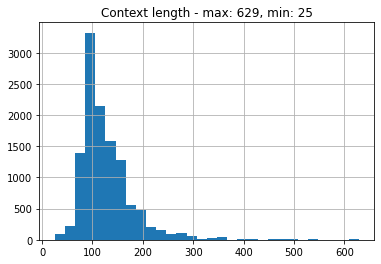

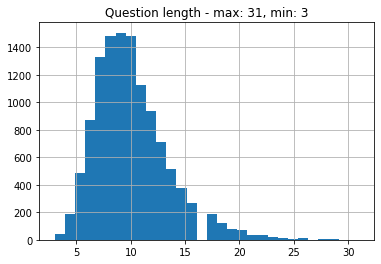

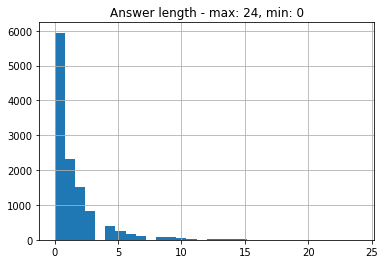

In [31]:
context_length_max = length_df['context_length'].max()
context_length_min = length_df['context_length'].min()
plt.title(f'Context length - max: {context_length_max}, min: {context_length_min}')
length_df['context_length'].hist(bins=30)
plt.show()

question_length_max = length_df['question_length'].max()
question_length_min = length_df['question_length'].min()
plt.title(f'Question length - max: {question_length_max}, min: {question_length_min}')
length_df['question_length'].hist(bins=30)
plt.show()

answer_length_max = int(length_df['answer_mode_length'].max())
answer_length_min = int(length_df['answer_mode_length'].min())
plt.title(f'Answer length - max: {answer_length_max}, min: {answer_length_min}')
length_df['answer_mode_length'].hist(bins=30)
plt.show()

Selected bins:

_Answer length:_
- Answerable questions only
- Following https://arxiv.org/pdf/1704.07415.pdf
- 1-9, >9 

_Context length:_
- 0-100, 100-200, 200-300, 300-400, 400-500, >500

_Question length:_
- 0-5, 5-10, 10-15, 15-20, 20-25, >25

In [34]:
length_df.head()

,id,context_length,question_length,answer_mode_length
0,56ddde6b9a695914005b9628,113,6,1
1,56ddde6b9a695914005b9629,113,6,4
2,56ddde6b9a695914005b962a,113,7,4
3,56ddde6b9a695914005b962b,113,5,1
4,56ddde6b9a695914005b962c,113,10,1


In [52]:
length_df['context_length_bin'] = pd.cut(
    length_df['context_length'], 
    bins=list(range(0, 501, 100)) + [999999],  # bins are right inclusive e.g. 500 in '400-500'
    labels=['0-100', '100-200', '200-300', '300-400', '400-500', '>500']
).astype(str)

In [60]:
length_df['question_length_bin'] = pd.cut(
    length_df['question_length'], 
    bins=list(range(0, 26, 5)) + [999999],  # bins are right inclusive e.g. 500 in '400-500'
    labels=['0-5', '5-10', '10-15', '15-20', '20-25', '>25']
).astype(str)

In [63]:
length_df.head()

,id,context_length,question_length,answer_mode_length,context_length_bin,question_length_bin
0,56ddde6b9a695914005b9628,113,6,1,100-200,5-10
1,56ddde6b9a695914005b9629,113,6,4,100-200,5-10
2,56ddde6b9a695914005b962a,113,7,4,100-200,5-10
3,56ddde6b9a695914005b962b,113,5,1,100-200,0-5
4,56ddde6b9a695914005b962c,113,10,1,100-200,5-10


In [67]:
length_df['answer_mode_length_bin'] = np.where(
    length_df['answer_mode_length'] > 9,
    '>9',
    length_df['answer_mode_length'].astype(str)
)

In [72]:
length_df['answer_mode_length_bin'].value_counts() / length_df.shape[0]

0     0.500716
1     0.196075
2     0.128864
3     0.070665
4     0.034532
5     0.020635
>9    0.013897
6     0.013560
7     0.009433
8     0.005812
9     0.005812
Name: answer_mode_length_bin, dtype: float64

In [73]:
length_df.head()

,id,context_length,question_length,answer_mode_length,context_length_bin,question_length_bin,answer_mode_length_bin
0,56ddde6b9a695914005b9628,113,6,1,100-200,5-10,1
1,56ddde6b9a695914005b9629,113,6,4,100-200,5-10,4
2,56ddde6b9a695914005b962a,113,7,4,100-200,5-10,4
3,56ddde6b9a695914005b962b,113,5,1,100-200,0-5,1
4,56ddde6b9a695914005b962c,113,10,1,100-200,5-10,1


In [74]:
length_df.drop(columns=['context_length', 'question_length', 'answer_mode_length'], inplace=True)

## Save

In [75]:
simple_categories_df = w8h_df.merge(length_df, on='id')
print(simple_categories_df.shape)
simple_categories_df.head()

(11873, 5)


,id,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin
0,56ddde6b9a695914005b9628,other,100-200,5-10,1
1,56ddde6b9a695914005b9629,when,100-200,5-10,4
2,56ddde6b9a695914005b962a,other,100-200,5-10,4
3,56ddde6b9a695914005b962b,who,100-200,0-5,1
4,56ddde6b9a695914005b962c,what,100-200,5-10,1


In [76]:
simple_categories_df = simple_categories_df.merge(
    squad_v2_val_df[['id', 'unanswerable']],
    on='id'
)

print(simple_categories_df.shape)
simple_categories_df.head()

(11873, 6)


,id,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable
0,56ddde6b9a695914005b9628,other,100-200,5-10,1,0
1,56ddde6b9a695914005b9629,when,100-200,5-10,4,0
2,56ddde6b9a695914005b962a,other,100-200,5-10,4,0
3,56ddde6b9a695914005b962b,who,100-200,0-5,1,0
4,56ddde6b9a695914005b962c,what,100-200,5-10,1,0


In [77]:
simple_categories_df.to_csv('data/processed/squad2_dev_simple_categories.csv', index=False)